## <center> Webscraping Project : Extract and Analyze Wedding Data & Respond to Client Inquiries Systematically </center>

---


### Overview:
[Fearless Photographers](https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8535)  is a wedding photography website where potential bride/grooms can inquire about photographers to cover their weddings. Similarly, interested and available photographers can mark themselves available to be considered by the couple. The couple can subsequently review the portfolio of photographers who expressed interest and initiate possible booking process/follow up discussions accordingly. In essence, the website provides a marketplace to connect buyers and sellers of wedding photography service. 

The core objectives of this exercise are the following:
1. Implement a webscraping application that extracts inquiry information from fearless website.
2. Aggregate, process, analyze and draw insights based on the data that have been scraped from fearlessphotographers.com 
3. Implement a mechanism to respond to wedding photography inquiries based on a set of predefined criteria (e.g. location, date etc.)
4. Deploy the application to a PaaS (Platform as a Service) provider so that scheduled jobs can be run to perform the scraping and responding tasks automatically at predefined intervals. 

#### Summary of key steps for implementation:
1. Scrape wedding inquiry information using Scrapy spider and XPath selectors.
2. Store the scraped data in a non-relational (MongoDB) database.
3. Scraped information include the following:
    - Client ID
    - Event date
    - Event location
    - Type of event
    - Number of photographers who already replied
    - Time of scrape
4. Implement a second spider that replies to client inquiries (on behalf of a given photographer) based on a set of predefined rules (e.g. reply if the wedding is in USA, Mexico or Canada).
5. When spider 2 replies to an inquiry, it also records the time of that response and inserts a new field into that collection, Replied (boolean). 
6. Write a script that runs the two spiders periodically. The Replied field in spider 2 helps filter out inquiries that have already been replied to, eliminating the possibility of spider 2's replying to an ever increasing number of inquiries in each run. 
7. Deploy the project to a PasS provider (Heroku).
    
    
---

Import all required libraries

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import seaborn as sns
import re
%matplotlib inline

- Create a function to concatenate multiple csv files from directory.
- Make the function robust so that it can handle missing files. 

In [126]:
def makeMaster(fileStartNum, fileEndNum,path="./Datasets/data{}.csv" ):
    '''
    A function that takes in directory path where csv files are saved,
    concatenates the individual csvs into a master dataframe,
    and handles FileNotFoundError if a file is missing from directory 
    '''
    files = [(path.format(x)) for x in range (fileStartNum,fileEndNum+1)]
    df = pd.DataFrame()
    for file in files:
        try:
            df = pd.concat([pd.read_csv(file),df])
        except FileNotFoundError:
            #print (file) #debugging to see which files are missing
            continue
    return df       

Concatenate multiple csv files (30 in this case) into a single dataframe.

In [127]:
wedding_data = makeMaster (1,30)

Check the dataframe size

In [128]:
wedding_data.shape

(7533, 7)

Check some sample data from the combined dataframe.

In [129]:
wedding_data.sample(5, random_state=101)

,ID,Name,Date,Location,Type,Replies,RequestLink
53,3553,Stephanie,"Friday, June 19, 2015","Dripping Springs, TX - USA",Small Wedding,"4 photographers near your location are available,25 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=3553
83,1583,Tobias,"Friday, September 27, 2013",Germany,\r\n\t\t,"4 photographers near your location are available,13 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=1583
65,6815,Emily,"Saturday, July 9, 2016","Washington, DC - USA",Other,"1 photographers near your location are available,10 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=6815
30,5030,NaN,NaN,NaN,NaN,NaN,https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=5030
195,3945,Kakeru,"Sunday, November 16, 2014",Nice - France,Other,"7 photographers near your location are available,5 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=3945


Define a function that outputs the variables with missing values and prints the % of missing values.

In [130]:
def missingValues (dataframe): 
    attr_missing_values = [x for x in dataframe.columns if dataframe[x].isnull().sum()>1]
    for x in attr_missing_values:
        print ("{} -> {} % missing value".format(x,np.round((dataframe[x].isnull().mean()*100),2)))

In [131]:
missingValues(wedding_data)

Name -> 19.26 % missing value
Date -> 19.26 % missing value
Location -> 19.26 % missing value
Type -> 19.26 % missing value
Replies -> 19.26 % missing value


- The % of missing values is homogeneous, so there must not have been any 'real' response for those urls that were used to crawl and scrape the data.
- Need to remove these rows and clean up the dataframe.

In [132]:
wedding_data.dropna(inplace = True)

Check that the rows with missing data have been dropped from the dataframe.

In [133]:
print (wedding_data.isnull().sum())
print (wedding_data.shape)

ID             0
Name           0
Date           0
Location       0
Type           0
Replies        0
RequestLink    0
dtype: int64
(6082, 7)


Check the frquency distributon of various wedding types.

In [134]:
wedding_data['Type'].value_counts()

 Small Wedding                  1520
 Big Wedding                    1451
\r\n\t\t                        1163
 Wedding                        413 
 Wedding - more than 6 hours    407 
 Other                          326 
 Wedding - less than 6 hours    236 
\r\n\t\t\t\t\t\t                186 
 Elopement                      153 
 Engagement                     151 
 Party                          46  
 Bar/Bat Mitzvah                11  
 Mariage - moins de 6 heures    2   
 Boda - más de 6 horas          2   
 Mariage - plus de 6 heures     2   
 Huwelijk - meer dan 6 uur      2   
 Nunta - mai mult de 6 ore      2   
 Maternity                      1   
 Свадьба - более 6 часов        1   
 Even                           1   
 Pre-Wedding                    1   
 Wedding - più di 6 ore         1   
 Nuntă                          1   
 Photo Session                  1   
 Casamento - mais de 6 horas    1   
 Baptism                        1   
Name: Type, dtype: int64

We notice some leading and trailing spaces on the category names. Need to remove these spaces. 

In [135]:
wedding_data['Type'] = wedding_data['Type'].str.strip()

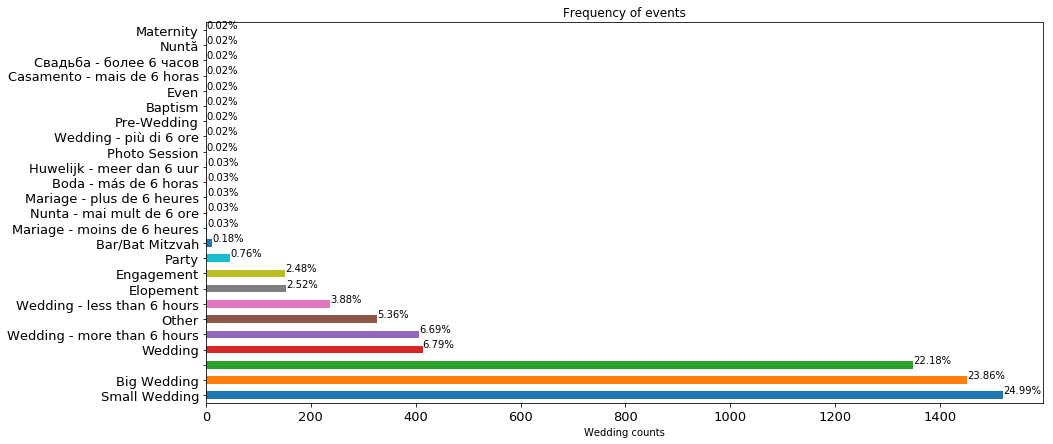

In [136]:
ax = wedding_data['Type'].value_counts().plot(kind='barh', figsize=(15,7),fontsize=13)
ax.set_alpha(0.8)
plt.title('Frequency of events')
plt.xlabel ('Wedding counts')

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, str(round((i.get_width()/total)*100, 2))+'%', fontsize=10)


---
#### Based on the distribution above:
1.  \r\n\t\t  and \r\n\t\t\t\t\t\t refer to inquiries where the user didn't provide any value for event type. These can be dropped for our analysis. The assumption here is that the distribution of the even types is homogenously applicable for the entries with missing wedding type value.
2. Non wedding event types that can be dropped:
        - Engagement
        - Other
        - Party
        - Bar/Bat Mitzvah
        - Baptism
        - Pre-Wedding
        - Photo Session
        - Even
        - Maternity
3. Weddings that need to be remapped: To simplify the analysis, we'll map all the weddings to either Small Wedding or Small Wedding.
        - Big weddings = {Wedding - more than 6 hours, Nunta - mai mult de 6 ore, Mariage - plus de 6 heures, Boda - más de 6 horas, Huwelijk - meer dan 6 uur, Wedding - più di 6 ore, Свадьба - более 6 часов, Casamento - mais de 6 horas}
        - Small Weddings = {Wedding - less than 6 hours, Mariage - moins de 6 heures}
---        

### Data Transformation: 
- Need to write a function to remove the non wedding events and to map the weddings in #3 to the appropriate categories. 
- We can see some inputs in various languages (Italian, French etc.)
- The task here is to normalize the various inputs (24 distinct values) into 3 categories:
    - Big weddings
    - Small Wddings
    - Weddings (uncategorized)

In [137]:
non_wedding_events = ['Engagement', 'Other', 'Party', 'Bar/Bat Mitzvah', 'Baptism', 'Pre-Wedding', 'Photo Session', 'Even', 'Maternity', 'Nuntă']
big_weddings = ['Big Wedding', 'Wedding - more than 6 hours', 'Nunta - mai mult de 6 ore', 'Mariage - plus de 6 heures', 
                'Boda - más de 6 horas', 'Huwelijk - meer dan 6 uur', 'Wedding - più di 6 ore', 'Свадьба - более 6 часов', 'Casamento - mais de 6 horas']
small_weddings = ['Small Wedding','Wedding - less than 6 hours', 'Mariage - moins de 6 heures', 'Elopement']

def cleanAndMapEvents (df):
    #Create a copy of raw dataframe
    df_clean = df.copy()
    
    #Drop the rows will null values for wedding type
    df_clean = df_clean[df_clean['Type'] != '']
    
    #Drop the rows where the values of Type column are in non_wedding_events, i.e drop non-weddings events
    df_clean = df_clean[df_clean['Type'].isin(non_wedding_events) == False]   
    
    #Replace the values in big_weddings with the value 'Big Weddigs'
    df_clean['Type'].replace(big_weddings, 'Big Weddings', inplace = True)
    
    #Replace the values in small_weddings with the value 'Small Weddigs'
    df_clean['Type'].replace(small_weddings, 'Small Weddings', inplace = True)
    
    return (df_clean)


In [138]:
cleaned_events_data = cleanAndMapEvents(wedding_data)
cleaned_events_data.sample (5, random_state= 101)

,ID,Name,Date,Location,Type,Replies,RequestLink
132,3132,Lauren,"Saturday, September 6, 2014","Liverpool, England - UK",Small Weddings,"10 photographers near your location are available,15 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=3132
10,6260,Anri,"Tuesday, February 16, 2016",Venice - Italy,Small Weddings,"25 photographers near your location are available,11 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=6260
96,6846,Isabella,"Saturday, August 20, 2016",Budapest - Hungary,Small Weddings,"2 photographers near your location are available,27 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=6846
246,7496,Jennifer,"Saturday, October 14, 2017","Milwaukee, WI - USA",Big Weddings,"5 photographers near your location are available,48 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=7496
61,7061,Aanne,"Friday, February 10, 2017",St Barthélémy - Caribbean,Big Weddings,"5 photographers near your location are available,67 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=7061


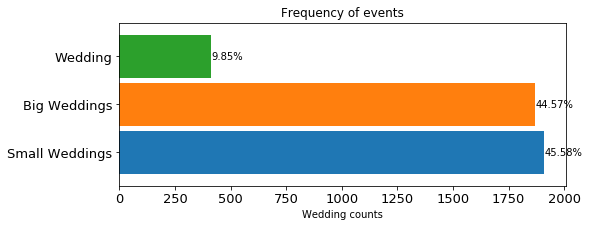

In [139]:
ax = cleaned_events_data['Type'].value_counts().plot(kind='barh', figsize=(8,3),fontsize=13, width = 0.9)
ax.set_alpha(0.8)
plt.title('Frequency of events')
plt.xlabel ('Wedding counts')

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, str(round((i.get_width()/total)*100, 2))+'%', fontsize=10)


** Key Takeaway ** :
Based on the frequency distribution above, we can see that big and small weddings are evently distrubuted (44.57% vs 45.58%)

----

### Process Replies Column

- The Replies column seem to be a descriptive column (text) containing information on the number of local and non local (global) photographers who marked themselves available.
- In the following section, we parse the content of the Replies column and create two new ones, Local_photogs and Global_photogs, containing the numbr of local and non local photographers who replies to the inquiries. 

In [140]:
pd.set_option('display.max_colwidth', -1)
cleaned_events_data['Replies'].sample(5, random_state = 101)

132    10 photographers near your location are available,15 photographers around the world are available
10     25 photographers near your location are available,11 photographers around the world are available
96     2 photographers near your location are available,27 photographers around the world are available 
246    5 photographers near your location are available,48 photographers around the world are available 
61     5 photographers near your location are available,67 photographers around the world are available 
Name: Replies, dtype: object

In [141]:
replies_parsed = cleaned_events_data

In [142]:
replies_parsed.head()

,ID,Name,Date,Location,Type,Replies,RequestLink
0,8250,David,"Saturday, June 15, 2019","Ithaca, NY - USA",Wedding,"18 photographers near your location are available,63 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8250
1,8251,Xinru,"Saturday, October 13, 2018",Singapore,Wedding,"7 photographers near your location are available,37 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8251
2,8252,Megan,"Sunday, October 7, 2018",Riomaggiore - Italy,Wedding,"50 photographers near your location are available,52 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8252
4,8254,Rajesh,"Friday, October 26, 2018",Mumbai - India,Wedding,"19 photographers near your location are available,38 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8254
5,8255,Marin,"Saturday, June 1, 2019",Bucharest,Wedding,"34 photographers near your location are available,57 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8255


** Function to extract the local and global number of replies**
- Write a function to extract the local and global photographer numbers.
- Make sure to replace NaN value with 0 (these are cases where no local/global photographer replied to the inquiry)
- Convert the numerical fields to int data type

In [182]:
# Local photographers
replies_parsed['local_replies'] = replies_parsed['Replies'].str.extract(r'(\d{1,3}\sphotographers near your location are available)')[0].str.strip(' photographers near your location are available')
replies_parsed['local_replies'] = replies_parsed['local_replies'].fillna(0).astype(int)

In [183]:
# Global photographers
replies_parsed['global_replies'] = replies_parsed['Replies'].str.extract(r'(\d{1,3}\sphotographers around the world are available)')[0].str.strip(' photographers around the world are available')
replies_parsed['global_replies'] = replies_parsed['global_replies'].fillna(0).astype(int)

In [184]:
replies_parsed.dtypes

ID                int64 
Name              object
Date              object
Location          object
Type              object
Replies           object
RequestLink       object
local_replies     int64 
global_replies    int64 
Country           object
State/City        object
dtype: object

In [187]:
cleaned_events_data = replies_parsed
cleaned_events_data.head(5)

,ID,Name,Date,Location,Type,Replies,RequestLink,local_replies,global_replies,Country,State/City
0,8250,David,"Saturday, June 15, 2019","Ithaca, NY - USA",Wedding,"18 photographers near your location are available,63 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8250,18,63,USA,"Ithaca, NY"
1,8251,Xinru,"Saturday, October 13, 2018",Singapore,Wedding,"7 photographers near your location are available,37 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8251,7,37,None,Singapore
2,8252,Megan,"Sunday, October 7, 2018",Riomaggiore - Italy,Wedding,"50 photographers near your location are available,52 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8252,50,52,Italy,Riomaggiore
4,8254,Rajesh,"Friday, October 26, 2018",Mumbai - India,Wedding,"19 photographers near your location are available,38 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8254,19,38,India,Mumbai
5,8255,Marin,"Saturday, June 1, 2019",Bucharest,Wedding,"34 photographers near your location are available,57 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8255,34,57,None,Bucharest


** Alternative method to extract local and global photographer replies:**
The two cells below describe an alternative function to extract local and global photographers numbers. However, the regex method that was used above is more robust, so we will stick with that. 

In [54]:
# df = cleaned_events_data['Replies'].str.split('photographers near your location are available', expand = True)
# cleaned_events_data['Local_photogs'] = df[0].where(df[0].str.len()<4)
# cleaned_events_data['Global_photogs'] = df[1].where(df[1].notna(),df[0]).str.replace('photographers around the world are available','').str.strip().str.replace(',','')
# cleaned_events_data.head(10)

In [55]:
# # cleaned_events_data['Local_photogs'].astype('int64')
# cleaned_events_data['Local_photogs'] = pd.to_numeric(cleaned_events_data['Local_photogs'], errors='coerce')
# cleaned_events_data['Global_photogs'] = pd.to_numeric(cleaned_events_data['Global_photogs'], errors='coerce')
# cleaned_events_data[['Global_photogs', 'Local_photogs']].info()

Inspect the refined dataframe.

---
### Locations Column 
- The Location column contain the event location information. 
- Pattern of location info follows a <city,State - Country> format.
- In the following cells, parse the content of the raw location data to extract city/state and country information. 
- Create two additional columns, Country and	State/City, to house the extracted information. 
- Conduct analysis and create summary view to look at the countries with highest wedding inquiries.
- Conduct analysis on the ratio of inquiries to local photographer replies to get a sense of relative competitiveness globally. 

In [188]:
cleaned_events_data['Country'] = cleaned_events_data['Location'].str.split('-', expand = True)[1].str.strip()
cleaned_events_data['State/City'] = cleaned_events_data['Location'].str.split('-', expand = True)[0].str.strip()
cleaned_events_data.sample(5, random_state = 101)

,ID,Name,Date,Location,Type,Replies,RequestLink,local_replies,global_replies,Country,State/City
132,3132,Lauren,"Saturday, September 6, 2014","Liverpool, England - UK",Small Weddings,"10 photographers near your location are available,15 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=3132,10,15,UK,"Liverpool, England"
10,6260,Anri,"Tuesday, February 16, 2016",Venice - Italy,Small Weddings,"25 photographers near your location are available,11 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=6260,25,11,Italy,Venice
96,6846,Isabella,"Saturday, August 20, 2016",Budapest - Hungary,Small Weddings,"2 photographers near your location are available,27 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=6846,2,27,Hungary,Budapest
246,7496,Jennifer,"Saturday, October 14, 2017","Milwaukee, WI - USA",Big Weddings,"5 photographers near your location are available,48 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=7496,5,48,USA,"Milwaukee, WI"
61,7061,Aanne,"Friday, February 10, 2017",St Barthélémy - Caribbean,Big Weddings,"5 photographers near your location are available,67 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=7061,5,67,Caribbean,St Barthélémy


In [189]:
cleaned_events_data.columns

Index(['ID', 'Name', 'Date', 'Location', 'Type', 'Replies', 'RequestLink',
       'local_replies', 'global_replies', 'Country', 'State/City'],
      dtype='object')

In [190]:
#Rearrange the columns of the dataframe
cleaned_events_data = cleaned_events_data[['ID', 'Name', 'Date','Type',
       'local_replies', 'global_replies', 'Country', 'State/City','RequestLink']]
cleaned_events_data.head()

,ID,Name,Date,Type,local_replies,global_replies,Country,State/City,RequestLink
0,8250,David,"Saturday, June 15, 2019",Wedding,18,63,USA,"Ithaca, NY",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8250
1,8251,Xinru,"Saturday, October 13, 2018",Wedding,7,37,None,Singapore,https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8251
2,8252,Megan,"Sunday, October 7, 2018",Wedding,50,52,Italy,Riomaggiore,https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8252
4,8254,Rajesh,"Friday, October 26, 2018",Wedding,19,38,India,Mumbai,https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8254
5,8255,Marin,"Saturday, June 1, 2019",Wedding,34,57,None,Bucharest,https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8255


** Breakdown by country ** : Find the top countries, i.e. countries with the highest number of inquiries.

In [191]:
top_countries = cleaned_events_data.groupby('Country').count()[['ID']].sort_values(by='ID', ascending = False).iloc[0:10]
top_countries

,ID
Country,
USA,1476
Romania,355
UK,299
Canada,204
India,153
France,152
Italy,129
Mexico,90
Greece,86


In [192]:
#Aggregate the remaining inquiries in a group called 'Other'
cleaned_events_data.groupby('Country').count()[['ID']].sort_values(by='ID', ascending = False).iloc[10:].sum()

ID    876
dtype: int64

In [202]:
pd.set_option('mode.chained_assignment', None)
cleaned_events_data ['Top_Country'] = np.where(cleaned_events_data['Country'].isin(top_countries.index), cleaned_events_data['Country'], 'Other')
cleaned_events_data ['Top_Country'].value_counts()

USA          1476
Other        1171
Romania      355 
UK           299 
Canada       204 
India        153 
France       152 
Italy        129 
Mexico       90  
Greece       86  
Caribbean    78  
Name: Top_Country, dtype: int64

In [203]:
cleaned_events_data.dtypes

ID                int64 
Name              object
Date              object
Type              object
local_replies     int64 
global_replies    int64 
Country           object
State/City        object
RequestLink       object
Top_Country       object
dtype: object

In [204]:
cleaned_events_data.head()

,ID,Name,Date,Type,local_replies,global_replies,Country,State/City,RequestLink,Top_Country
0,8250,David,"Saturday, June 15, 2019",Wedding,18,63,USA,"Ithaca, NY",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8250,USA
1,8251,Xinru,"Saturday, October 13, 2018",Wedding,7,37,None,Singapore,https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8251,Other
2,8252,Megan,"Sunday, October 7, 2018",Wedding,50,52,Italy,Riomaggiore,https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8252,Italy
4,8254,Rajesh,"Friday, October 26, 2018",Wedding,19,38,India,Mumbai,https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8254,India
5,8255,Marin,"Saturday, June 1, 2019",Wedding,34,57,None,Bucharest,https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8255,Other


In [197]:
cleaned_events_data.groupby ('Top_Country').agg({'ID':'count', 'local_replies':'sum'})

,ID,local_replies
Top_Country,,
Canada,204,1343
Caribbean,78,197
France,152,3073
Greece,86,1077
India,153,1444
Italy,129,3437
Mexico,90,1296
Other,1171,8284
Romania,355,4409


In [198]:
summary_data = cleaned_events_data.groupby ('Top_Country').agg({'ID':'count','local_replies':'sum', 'global_replies': 'sum'}).rename(columns = {'ID':'Inquiry_count'}).sort_values('Inquiry_count', ascending = False)
summary_data

,Inquiry_count,local_replies,global_replies
Top_Country,,,
USA,1476,10546,37483
Other,1171,8284,43328
Romania,355,4409,7570
UK,299,6497,10532
Canada,204,1343,4490
India,153,1444,4253
France,152,3073,5958
Italy,129,3437,4281
Mexico,90,1296,2627


---

#### Summary view (data breakdown per country): 
- Inquiry_count: Number of inquiries per country.
- Local_photogs: Sum of local photographers who replied per country.
- Global_photogs: Sum of non local photographers who replied per country.
- %Inquiry_share: Number of inquiries per country as a % of the global number.
- Inquiry_per_local_photog: Number of inquiries per local photog's interest. This is a measure of crowding in the local market. The lower the number, the more saturated that market for local photogs. 
- %Inquiry_per_global_photog: Number of inquiries per global photog's interest. This is a measure of photographer interest globally (minus local photographers). A higher number would indicate more desirable shooting location, condition etc. 


In [200]:
summary_data['%Inquiry_share'] = np.round(summary_data['Inquiry_count']*100/summary_data['Inquiry_count'].sum(),2)
summary_data['inquiry_per_local_photog'] = np.round(summary_data['Inquiry_count']/summary_data['local_replies'],5)
summary_data['%inquiry_per_global_photog'] = np.round(summary_data['Inquiry_count']/summary_data['global_replies'].sum(),5)
summary_data

,Inquiry_count,local_replies,global_replies,%Inquiry_share,inquiry_per_local_photog,%inquiry_per_global_photog
Top_Country,,,,,,
USA,1476,10546,37483,35.20,0.13996,0.01163
Other,1171,8284,43328,27.93,0.14136,0.00923
Romania,355,4409,7570,8.47,0.08052,0.00280
UK,299,6497,10532,7.13,0.04602,0.00236
Canada,204,1343,4490,4.87,0.15190,0.00161
India,153,1444,4253,3.65,0.10596,0.00121
France,152,3073,5958,3.63,0.04946,0.00120
Italy,129,3437,4281,3.08,0.03753,0.00102
Mexico,90,1296,2627,2.15,0.06944,0.00071


In [209]:
summary_data['%inquiry_per_global_photog'].sort_values(ascending = False)

Top_Country
USA          0.01163
Other        0.00923
Romania      0.00280
UK           0.00236
Canada       0.00161
India        0.00121
France       0.00120
Italy        0.00102
Mexico       0.00071
Greece       0.00068
Caribbean    0.00061
Name: %inquiry_per_global_photog, dtype: float64

### Key takeaways from geographical analysis:
Based on the data extracted and analyzed from fearlessphotographers website:
- The US market is, by a large margin, the biggest wedding photography market. The 35% of the inquiries are for weddings in the US whereas the next top location, Romania, accounts for only 8.4% of inquiries.
- The number of local photographer replies in US also far exceeds that of any other region. US had 10,546 local photographer replies with UK being in second place with 6497 replies.
- Romania seems to be an outlier. There are lot of inquiries coming from Romania (second highest in ranking) and the country seems to have a large population of local photographers as well (4409.0/10546.0), ~ 40% that of the US, the biggest market.
- The reasons for Romania's popularity both in term of demand and supply could stem from a number of reasons - perhaps fearlessohotographers is really popular there, or perhaps the website advertises themselves disproportionately in Romania. Without further data, we cannot make any further deductions.
- Local competitiveness: The Caribbean is the least crowded country with local photographers. At the same time it is most crowded with global photographers. These observations suggest that The Caribbean is a very popular destination wedding location. Hence, the ratio of demand to local supply is in favor of the local suppliers, but that edge is dampened by the exuberance of global photographers, many of whom are keen to photograph in this beautiful (and potentially high paying) destination.
- Following the Caribbean, Greece, Mexico and Italy are also among the most popular destinations for the global photographers (these are all prime destination wedding locations). 

    

---